# Machine Learning lab - Attribute selection
Source:
- Tabular Playground Series - Jun 2021
- https://www.kaggle.com/competitions/tabular-playground-series-jun-2021

We have available 
- the data file, `data_train.csv`
- the independent test file `data_test.csv`

Workflow:

1. load `data_train.csv` and do some exploration (the number of columns is not small, avoid using `pairplots`, it would be very slow and undreadable)
1. cancel useless columns, if any, use as target the `target` column, separate predicting from target into `X_full` and `y`
1. split `X_full` and `y` data into __train__ and __test__; since the file is quite large, for a faster development use not more than 2000 rows for training, and the remaining for testing
1. prepare a data frame to collect the results and a list to store all the estimators that will be fitted
1. train and test using some classification models with score `f1_score`
    - for each classification model
        - fit the model with cross validation and store it in the list of estimators
        - predict with the test set, 
        - produce a classsification report and store the values in the results dataframe
1. Try unsupervised attribute selection: use `PCA` to keep only the transformed features able to explain, cumulatively, approximately 80% of the total variance
1. store in `X_pca` the remaining, transformed variables
1. split the `X_pca` and y into __train__ and __test__ as in 3
1. train and test as in 5
1. Try supervised attrubute selection: use `SelectKBest` as selector and `mutual_info_classif` as estimator of the relationship between each feature and the target, 
1. set the `k` parameter of `SelectKBest` to the number of surviving features determined in 6, split the data into train and test
1. fit and transform the data 
    - fit and transform with the selector using `X_train`
    - transform `X_test` using the fitted selector
1. train and test as in 5
1. show the results and the confusion matrix for the best model
1. show all the results sorted for decreasing scoring, decide which is the best solution and comment why
1. Final test
    - load the test data
    - train the best model with the `X` data (possibily reduced, according to the best solution)
    - predict for `X_final_test`
    - show the confusion matrix and the classification report 

#### Import libraries and prepare the constant values that will be used

In [2]:
#Tabular Playground Series - Jun 2021
#https://www.kaggle.com/competitions/tabular-playground-series-jun-2021


import warnings
warnings.filterwarnings('ignore') # uncomment this line to suppress warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder # for encoding categorical target labels
from sklearn.feature_selection import SelectKBest # for supervised selection of best features
                                 

In [3]:
# constants
file_path = "../data/feature-selection/" # path to the data files
data_file = "data_train.csv"
test_file = "data_test.csv"
train_size = 0.0125 # train size chosen to have a few tousands of elements
cutoff_variance = .8 # the total amount of variance explained by the selected transformed features with PCA
cv = 5               # number of folds for cross-validation
random_state = 42    # seed for random number generator
np.random.seed(random_state) # this sets the random sequence. 
                             # Setting this the perfect repeatability is guaranteed
                             # when re-execute the entire notebook

In [4]:
# comment models for a quick test
model_lbls = ['dt' # decision tree
             ,'rf'   # random forest
            ]

# models to be tested with hyperparameters
models = {
    'dt': {'name': 'Decision Tree',
           'estimator': DecisionTreeClassifier(random_state=random_state),
           'param': [{'max_depth': [*range(1,20)],'class_weight':[None,'balanced']}],
          },
    'rf': {'name': 'Random forest',
           'estimator': RandomForestClassifier(random_state=random_state),
           'param': [{
                      # 'max_depth': [*range(4,30)]
                      'max_depth': [*range(4,30,4)]
                    #  ,'n_estimators':[*range(20,80,5)]
                     ,'n_estimators':[*range(10,30,5)]
                     ,'class_weight': [None,'balanced']
                      }]
          }

}

scoring = 'f1_macro'


## 1. load the data
Do also some exploration: show the size, the description and the number of unique values in features, in order to catch possibile identifiers to be dropped

In [5]:
df = pd.read_csv(file_path+data_file)
print("Shape of the data {}".format(df.shape))

Shape of the data (160000, 77)


In [6]:
# show 10 random records
df.sample(n=10, axis=0, replace=False, random_state = random_state)

,id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,target
120476,69762,0,0,0,16,0,6,0,0,0,...,0,0,0,0,0,2,0,0,0,Class_8
32693,23274,1,17,0,41,2,0,0,0,1,...,6,6,19,0,3,1,1,0,1,Class_6
79958,160394,0,0,0,1,0,0,0,1,0,...,0,0,0,0,1,0,0,4,1,Class_6
76366,189455,0,0,1,5,0,0,0,1,0,...,0,0,0,2,0,0,2,0,0,Class_9
82343,158523,0,0,0,6,0,1,0,1,7,...,0,2,0,0,4,29,2,0,0,Class_8
142834,131226,0,1,1,9,0,0,0,1,0,...,0,1,0,0,1,0,0,0,0,Class_6
116845,32995,1,7,5,2,0,1,0,1,1,...,3,3,2,1,3,0,2,0,0,Class_3
159721,180219,0,0,1,0,0,6,0,0,7,...,0,0,1,5,0,5,1,0,0,Class_6
61783,94564,2,0,1,7,0,0,0,1,11,...,0,1,1,0,0,1,2,10,0,Class_8
157041,31757,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Class_9


In [7]:
df.describe()

,id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74
count,160000.000000,160000.000000,160000.000000,160000.000000,160000.000000,160000.000000,160000.000000,160000.000000,160000.000000,160000.000000,...,160000.000000,160000.000000,160000.000000,160000.000000,160000.000000,160000.000000,160000.000000,160000.000000,160000.000000,160000.000000
mean,99877.897613,0.968950,1.166888,2.228556,2.287619,0.797669,1.430650,1.010156,0.672425,1.950850,...,1.801138,0.510644,1.835100,0.913763,1.595312,1.226144,0.806444,1.294150,2.935406,0.631750
std,57758.706261,3.912136,4.007328,6.493048,7.525296,2.955533,5.161323,3.952009,2.229554,3.946011,...,5.052175,1.879700,7.194775,3.838913,4.842575,4.859560,2.448888,4.297699,10.765003,3.923869
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,49801.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,99768.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,149957.250000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,2.000000,...,1.000000,0.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,199997.000000,61.000000,51.000000,64.000000,70.000000,38.000000,76.000000,43.000000,30.000000,38.000000,...,54.000000,24.000000,79.000000,55.000000,65.000000,67.000000,30.000000,61.000000,130.000000,52.000000


### Show the number of unique values in each column: a number equal to the number of rows most likely indicates an identifier, that is useless for machine learning and should be dropped
Showing only the biggest one in decreasing order makes easier the interpretation

In [8]:
df.nunique().sort_values(ascending=False)[:10]

id            160000
feature_15       104
feature_60        94
feature_73        90
feature_59        88
feature_46        87
feature_28        78
feature_32        77
feature_54        72
feature_61        70
dtype: int64

#### Eplore the target

In [9]:
target = 'target'
classes = df[target].unique()
classes.sort()
print(classes)

['Class_1' 'Class_2' 'Class_3' 'Class_4' 'Class_5' 'Class_6' 'Class_7'
 'Class_8' 'Class_9']


## 2. cancel useless columns, if any, prepare the features and the target 
use as target the `target` column, separate predicting from target into `X_full` and `y`

In [10]:
X_full = df.drop(['id', target], axis=1) # drop the id and target columns
# le = LabelEncoder()
y = df[target] #le.fit_transform(df[target])  # target column

In [11]:
X_full.head()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74
0,0,0,0,4,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
1,0,0,10,35,2,0,0,1,10,0,...,1,0,4,1,0,26,0,0,0,0
2,3,0,4,20,0,7,0,1,1,0,...,0,0,1,8,0,4,1,0,2,0
3,0,2,1,1,1,0,0,0,5,2,...,6,4,0,3,0,0,0,1,0,0
4,0,4,2,4,0,2,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0


## 3. Split the entire dataset into train and test

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_full, y
                                                    , train_size = train_size
                                                    , random_state = random_state) # default Train 0.75- Test 0.25
print("There are {} samples in the training dataset".format(X_train.shape[0]))
print("There are {} samples in the testing dataset".format(X_test.shape[0]))
print("Each sample has {} features".format(X_full.shape[1]))

There are 2000 samples in the training dataset
There are 158000 samples in the testing dataset
Each sample has 75 features


In [13]:
from sklearn.model_selection import ParameterGrid
trials = {lbl: len(list(ParameterGrid(models[lbl]['param']))) for lbl in model_lbls}
print("The number of trials for each model is {}".format(trials))

The number of trials for each model is {'dt': 38, 'rf': 56}


## 4. Prepare a data frame to collect the results and a list to store all the estimators that will be fitted

In [14]:
clfs = [] # list of classifiers
results = pd.DataFrame(columns=['dataset' # dataset full or reduced
                               ,'model','best_params','accuracy','precision_macro','recall_macro','f1_macro'])

## 5. train classifiers with the entire dataset

In [15]:
dataset = 'full' #

In [16]:
for m in model_lbls:
    clf = GridSearchCV(models[m]['estimator'], models[m]['param'], cv=cv,
                        scoring = scoring,
                        )
    clf.fit(X_train, y_train)
    clfs.append(clf)
    y_true, y_pred = y_test, clf.predict(X_test)
    # y_preds.append(y_pred)
    cr = classification_report(y_true,y_pred, output_dict=True
                                , zero_division=1
                                )
    # add the results to the end of dataframe
    results.loc[len(results)] = [dataset,models[m]['name'],clf.best_params_
                                ,cr['accuracy']
                                ,cr['macro avg']['precision']
                                ,cr['macro avg']['recall']
                                ,cr['macro avg']['f1-score']]

In [17]:
display(results[results.dataset==dataset]\
            .drop('dataset',axis=1)\
            .style.format(precision=3)\
            .set_caption('Results for dataset "{}"'.format(dataset)))

,model,best_params,accuracy,precision_macro,recall_macro,f1_macro
0,Decision Tree,"{'class_weight': None, 'max_depth': 11}",0.260,0.146,0.153,0.147
1,Random forest,"{'class_weight': 'balanced', 'max_depth': 8, 'n_estimators': 15}",0.259,0.159,0.169,0.159


## 6. Try unsupervised feature selection: 
- use `PCA` to keep only the transformed features able to explain, cumulatively, approximately 80% of the total variance
- execute the transformation of the feature part: the new dataset has the same number of features as the original one
- show the explained variance for each transformed features
    - new features are sorted for decreasing explained variance

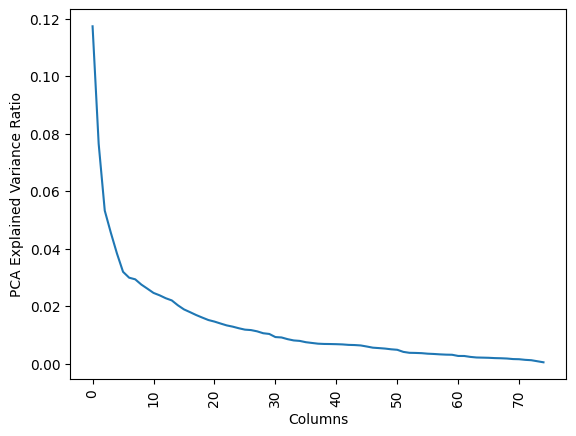

In [18]:
dataset = 'reduced_PCA' #
pca = PCA() # create a PCA object without restrictions: all components will be calculated

X_trans = pca.fit_transform(X_full)
# .explained_variance_ratio_ contains the percentage of variance explained by each of the components
plt.plot(range(X_full.shape[1]), pca.explained_variance_ratio_);

plt.xlabel('Columns')
plt.ylabel('PCA Explained Variance Ratio')

plt.xticks(rotation = 90)

plt.show()


In [19]:
# the n_components parameter of PCA is the number of components to keep (if integer)
# or the percentage variance to explain (if float)
pca = PCA(n_components=cutoff_variance)
X_pca = pca.fit_transform(X_full)
k_pca = X_pca.shape[1] # number of transformed features - it will be used as a parameter for SelectKBest
explained_variance = np.cumsum(pca.explained_variance_ratio_)[X_pca.shape[1]-1]
    # the total amount of variance explained by the selected transformed features
print("Used the top {} transformed variables, they explain {:.2f}% of the variance"\
      .format(X_pca.shape[1], explained_variance*100))

Used the top 31 transformed variables, they explain 80.67% of the variance


## 8. Split the dataset reduced with PCA into train and test

In [20]:
# from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_pca, y
                                                    , train_size = train_size
                                                    , random_state = random_state) # default Train 0.75- Test 0.25
print("Experimentng with the PCA reduced dataset")
print("There are {} samples in the training dataset".format(X_train.shape[0]))
print("There are {} samples in the testing dataset".format(X_test.shape[0]))
print("Each sample has {} features".format(X_pca.shape[1]))

Experimentng with the PCA reduced dataset
There are 2000 samples in the training dataset
There are 158000 samples in the testing dataset
Each sample has 31 features


## 9. Train and test the dataset reduced with PCA

In [21]:
for m in model_lbls:
    clf = GridSearchCV(models[m]['estimator'], models[m]['param'], cv=cv,
                        scoring = scoring,
                        )
    clf.fit(X_train, y_train)
    clfs.append(clf)
    y_true, y_pred = y_test, clf.predict(X_test)
    # y_preds.append(y_pred)
    cr = classification_report(y_true,y_pred, output_dict=True
                                , zero_division=1
                                )
    results.loc[len(results)] = [dataset,models[m]['name'],clf.best_params_
                                # ,(clf.cv_results_['mean_fit_time'].sum()+clf.cv_results_['mean_score_time'].sum())*n_splits
                                ,cr['accuracy']
                                ,cr['macro avg']['precision']
                                ,cr['macro avg']['recall']
                                ,cr['macro avg']['f1-score']]

In [22]:
display(results[results.dataset==dataset]\
            .drop('dataset',axis=1)\
            .style.format(precision=3)\
            .set_caption('Results for dataset "{}"'.format(dataset)))

,model,best_params,accuracy,precision_macro,recall_macro,f1_macro
2,Decision Tree,"{'class_weight': None, 'max_depth': 6}",0.279,0.258,0.148,0.134
3,Random forest,"{'class_weight': 'balanced', 'max_depth': 8, 'n_estimators': 20}",0.251,0.155,0.160,0.156


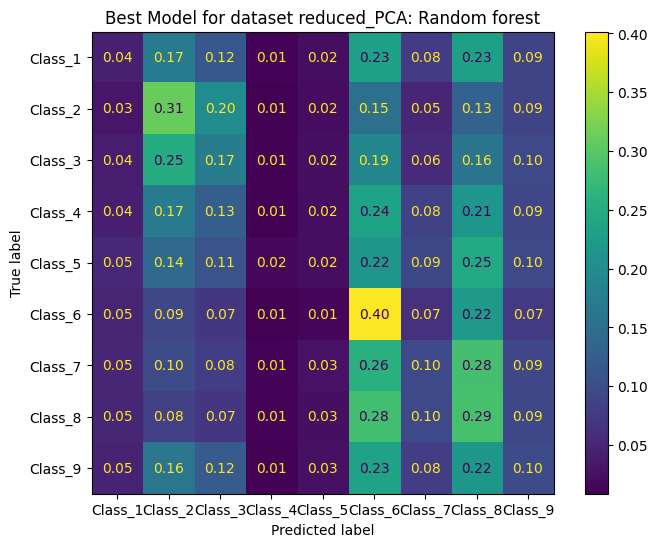

In [23]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

best_row = results.loc[results.dataset==dataset, scoring].idxmax(axis=0)
fig, ax = plt.subplots(figsize=(8, 6))  # Set figure size for each iteration
disp = ConfusionMatrixDisplay.from_estimator(
    X=X_test, y=y_test, estimator=clfs[best_row], normalize='true', ax=ax
)

# Format numbers in the confusion matrix to two decimal places
if disp.text_ is not None:  # Ensure text annotations exist
    for text_element in disp.text_.ravel():  # Flatten in case of a 2D array
        text_element.set_text(f"{float(text_element.get_text()):.2f}")

disp.ax_.set_title(f"Best Model for dataset {dataset}: {results.at[best_row, 'model']}")

plt.show()


## 10. try supervised feature selection 
use `SelectKBest` as selector and `mutual_info_classif` as estimator of the relationship between each feature and the target

## 11. Split into train and test and set the number of features to select as the number of features in `X_pca`

In [24]:
from sklearn.feature_selection import mutual_info_classif, SelectKBest
X_train, X_test, y_train, y_test = train_test_split(X_full, y
                                                    , train_size = train_size
                                                    , random_state = random_state) # default Train 0.75- Test 0.25
k_best = k_pca  # Number of top features to select, same as the number of selected PCA components

## 12. fit and transform the data
- fit and transform with the selector using `X_train`
- transform `X_test` using the fitted selector

In [25]:
kbest = SelectKBest(mutual_info_classif, k=k_best)
X_train = kbest.fit_transform(X_train, y_train)
X_test = kbest.transform(X_test)
dataset = 'reduced_SelectKBest' 

## 13. Train and test

In [26]:
for m in model_lbls:
    clf = GridSearchCV(models[m]['estimator'], models[m]['param'], cv=cv,
                        scoring = scoring,

                        )

    clf.fit(X_train, y_train)
    clfs.append(clf)
    y_true, y_pred = y_test, clf.predict(X_test)
    # y_preds.append(y_pred)
    cr = classification_report(y_true,y_pred, output_dict=True
                                , zero_division=1
                                )
    results.loc[len(results)] = [dataset,models[m]['name'],clf.best_params_
                                # ,(clf.cv_results_['mean_fit_time'].sum()+clf.cv_results_['mean_score_time'].sum())*n_splits
                                ,cr['accuracy']
                                ,cr['macro avg']['precision']
                                ,cr['macro avg']['recall']
                                ,cr['macro avg']['f1-score']]

In [27]:
## 14. Show the results

In [28]:
display(results[results.dataset==dataset]\
            .drop('dataset',axis=1)\
            .style.format(precision=3)\
            .set_caption('Results for dataset "{}"'.format(dataset)))

,model,best_params,accuracy,precision_macro,recall_macro,f1_macro
4,Decision Tree,"{'class_weight': None, 'max_depth': 11}",0.267,0.150,0.160,0.150
5,Random forest,"{'class_weight': 'balanced', 'max_depth': 16, 'n_estimators': 20}",0.302,0.159,0.167,0.152


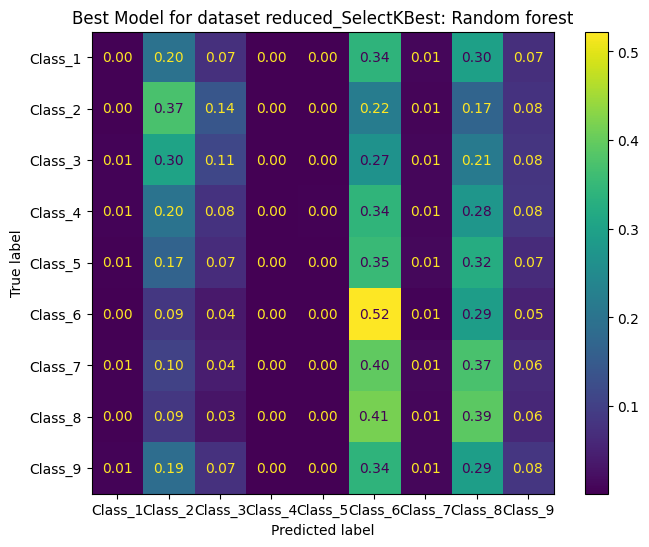

In [29]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

best_row = results.loc[results.dataset==dataset, scoring].idxmax(axis=0)
fig, ax = plt.subplots(figsize=(8, 6))  # Set figure size
disp = ConfusionMatrixDisplay.from_estimator(
    X=X_test, y=y_test, estimator=clfs[best_row], normalize='true', ax=ax
)

# Format numbers in the confusion matrix to two decimal places
if disp.text_ is not None:  # Ensure text annotations exist
    for text_element in disp.text_.ravel():  # Flatten in case of a 2D array
        text_element.set_text(f"{float(text_element.get_text()):.2f}")

disp.ax_.set_title(f"Best Model for dataset {dataset}: {results.at[best_row, 'model']}")

plt.show()


In [30]:
results.sort_values(by='f1_macro',ascending=False)

,dataset,model,best_params,accuracy,precision_macro,recall_macro,f1_macro
1,full,Random forest,"{'class_weight': 'balanced', 'max_depth': 8, '...",0.258994,0.159341,0.168936,0.159464
3,reduced_PCA,Random forest,"{'class_weight': 'balanced', 'max_depth': 8, '...",0.251152,0.155481,0.160261,0.156187
5,reduced_SelectKBest,Random forest,"{'class_weight': 'balanced', 'max_depth': 16, ...",0.302253,0.159165,0.166934,0.151957
4,reduced_SelectKBest,Decision Tree,"{'class_weight': None, 'max_depth': 11}",0.267025,0.150313,0.159941,0.150368
0,full,Decision Tree,"{'class_weight': None, 'max_depth': 11}",0.259551,0.145943,0.152558,0.146764
2,reduced_PCA,Decision Tree,"{'class_weight': None, 'max_depth': 6}",0.278557,0.257818,0.148100,0.134138


## Comment
Random Forest gives always the best result for `f1_macro` score, and the numbers are very similar (the difference is in the third decimal).

On the other hand, the solution with the `reduced_SelectKBest` has the best accuracy, for this reason we choose number 5 as the final solution

In [31]:
model, best_params, dataset = \
    results.loc[results['f1_macro'].idxmax(axis=0),['model','best_params','dataset']]
print("The best model is '{}' with the dataset '{}' and the following parameters:\n {}"\
    .format(str.strip(model), dataset, best_params))

The best model is 'Random forest' with the dataset 'full' and the following parameters:
 {'class_weight': 'balanced', 'max_depth': 8, 'n_estimators': 15}


## 16. Final test
 - load the test data
    - train the best model with the `X` data (possibily reduced, according to the best solution)
    - predict for `X_final_test`
    - show the confusion matrix and the classification report 

In [32]:
df_test = pd.read_csv(file_path+test_file)
y_test = df_test['target']
X_red = kbest.fit_transform(df_test.drop(['id','target'], axis=1), y_test)
print("Rows in test file {}".format(df_test.shape[0]))
rf = RandomForestClassifier(random_state=random_state, **best_params)
rf.fit(X_full, y)
y_test_pred = rf.predict(df_test.drop(['id','target'], axis=1))
# df_test['target'] = y_test_pred #le.inverse_transform(y_test_pred)
# df_test[['id', 'target']].to_csv('submission.csv', index=False)

Rows in test file 40000


In [33]:
print(classification_report(y_test,y_test_pred))

              precision    recall  f1-score   support

     Class_1       0.08      0.02      0.03      1873
     Class_2       0.28      0.56      0.38      4884
     Class_3       0.10      0.11      0.10      3007
     Class_4       0.03      0.05      0.03       893
     Class_5       0.02      0.06      0.03       625
     Class_6       0.46      0.38      0.42     10357
     Class_7       0.10      0.10      0.10      2926
     Class_8       0.36      0.36      0.36     10239
     Class_9       0.14      0.04      0.06      5196

    accuracy                           0.28     40000
   macro avg       0.17      0.19      0.17     40000
weighted avg       0.28      0.28      0.27     40000



#### Show the final confusion matrix

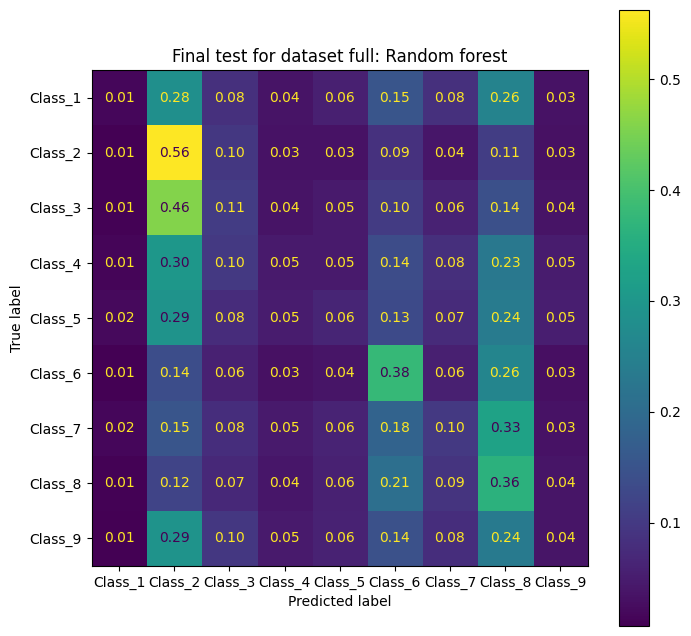

In [34]:
fig, ax = plt.subplots(figsize=(8, 8))  # Set figure size for each iteration
disp = ConfusionMatrixDisplay.from_predictions(
    y_test, y_test_pred, normalize='true', ax=ax
)
# Format numbers in the confusion matrix to two decimal places
if disp.text_ is not None:  # Ensure text annotations exist
    for text_element in disp.text_.ravel():  # Flatten in case of a 2D array
        text_element.set_text(f"{float(text_element.get_text()):.2f}")

disp.ax_.set_title(f"Final test for dataset {dataset}: {results.at[best_row, 'model']}")

plt.show()
